In [1]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import math
import pathlib
import pickle
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats

from sklearn import metrics, neighbors, linear_model, preprocessing, svm
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold, StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)

In [23]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                #print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            #print('\nSubj/Visit %d,prec=%.3f,rec=%.3f,Spec=%.3f,auroc_train=%.3f,auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),spec,auroc_train,auroc))
            s+=1

        #print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        #np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        #np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        #np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 
                          'auroc':np.nanmean(auroc_all)},index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 




def LOSOMultiClass(Data,X,y,groups,model,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','RMS'])
    groupres = {} #results on each group for each model
    
    acc_all=[]; acc_train=[] 
    f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
    auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]
    RMS_all = []
    
    clf = model[0][0]; model_name = model[0][1]          
    print('Training %s'%model_name)
    s = 0
    #LOSO CV for current classifier
    for train_index, test_index in subj.split(X, y, groups):
    #leave one in:
        if LOin:
            tridx = train_index.copy()
            train_index = test_index.copy()
            test_index = tridx
        Xtr, Xte = X[train_index], X[test_index]
        ytr, yte = y[train_index], y[test_index]
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            #print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        #yscore = clf.predict_proba(Xte)
        #yscore = yscore[:,1]

        #accuracy on train set
        
        RMS=0
        for yp,yt in zip(ypred,y):
            RMS += ((yp - yt)**2)
        RMS = RMS / len(y)
        RMS = math.sqrt(RMS)
        
        RMS_all.append(RMS)
        
        groupres[model_name] = {'RMS':RMS_all}
        
        r = pd.DataFrame({'model':model_name, 'RMS':np.nanmean(RMS_all)},index=[0])
        results = pd.concat((results,r))
        
    return results, groupres

In [3]:
folder_path = r'Z:CIS-PD Study'
subjects_path = r'Z:\CIS-PD Study\Subjects' #Windows remote path
dict_path = 'Z:\CIS-PD Study\Data_dict'
scores_path = r'Z:\CIS-PD Study\Scores' #remote repo
features_path = r'Z:\CIS-PD Study\FeatureMatrix' #remote repo
results_path = r'C:\Users\LU-RT&O\Documents\Git\Results'

# Binary Classifier

## Watch

In [4]:
symptom = 'Tremor'

watch_res_all = pd.DataFrame()

t1=time.time()

watch_res_freq_all = []

for freq in [50,45,40,35,30,25,20,15,10,5]:

    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res['auroc std'] = np.nanstd(res_group['Random Forest']['auroc'])
    res = res[['Sampling Rate','auroc','auroc std']]
    watch_res_all = pd.concat((watch_res_all,res))
    watch_res_freq_all.append(res_group)
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

50
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.388+/-0.233, prec=0.486+/-0.308, rec=0.420+/-0.238, auprc=0.530+/-0.275, auroc=0.784+/-0.183
45
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.373+/-0.236, prec=0.485+/-0.323, rec=0.345+/-0.221, auprc=0.513+/-0.272, auroc=0.776+/-0.179
40
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.400+/-0.246, prec=0.508+/-0.328, rec=0.408+/-0.217, auprc=0.538+/-0.295, auroc=0.783+/-0.183
35
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.390+/-0.235, prec=0.489+/-0.321, rec=0.419+/-0.227, auprc=0.526+/-0.273, auroc=0.783+/-0.181
30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.373+/-0.245, prec=0.489+/-0.332, rec=0.346+/-0.210, auprc=0.519+/-0.293, auroc=0.766+/-0.183
25
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.366+/-0.226, prec=0.501+/-0.340, rec=0.320+/-0.193, auprc=0.514+/-0.286, auroc=0.759+/-0.183
20
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.388+/-0.254, prec=0.504+/-0.332, rec=0.358+/-0.261, auprc=0.532+/-0.295, auroc=0.749+/-0.190
15
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.332+/-0.188, prec=0.455+/-0.303, rec=0.318+/-0.211, auprc=0.498+/-0.257, auroc=0.723+/-0.191
10
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.241+/-0.131, prec=0.397+/-0.291, rec=0.225+/-0.153, auprc=0.434+/-0.252, auroc=0.677+/-0.171
5
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.204+/-0.151, prec=0.367+/-0.332, rec=0.194+/-0.170, auprc=0.436+/-0.256, auroc=0.616+/-0.223
Elapsed time = 5.850 min


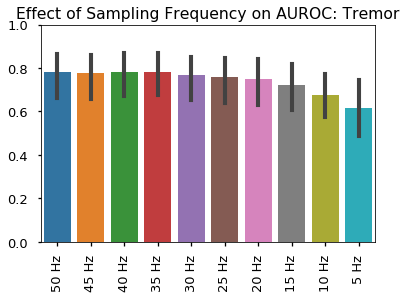

In [5]:
groups = watch_res_all['Sampling Rate'].values
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(watch_res_freq_all)):
    if len(watch_res_freq_all[i]['Random Forest']['auroc']) < 7:
        L = len(watch_res_freq_all[i]['Random Forest']['auroc'])
        watch_res_freq_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[groups[i]] = watch_res_freq_all[i]['Random Forest']['auroc']   
    tremor_auc = watch_res_freq_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(tremor_auc)) #mean across visits
    auc_std.append(np.nanstd(tremor_auc))

sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.ylim([0,1.0])
plt.title('Effect of Sampling Frequency on AUROC: Tremor')
plt.savefig('Results/Downsample/BinaryWatchTremor.png',format='png',dpi=1000)

In [6]:
symptom = 'Bradykinesia'

watch_res_all = pd.DataFrame()

t1=time.time()

watch_res_freq_all = []

for freq in [50,45,40,35,30,25,20,15,10,5]:

    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res['auroc std'] = np.nanstd(res_group['Random Forest']['auroc'])
    res = res[['Sampling Rate','auroc','auroc std']]
    watch_res_all = pd.concat((watch_res_all,res))
    watch_res_freq_all.append(res_group)
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

50
Training Random Forest
f1_test=0.590+/-0.234, prec=0.598+/-0.284, rec=0.710+/-0.176, auprc=0.625+/-0.269, auroc=0.629+/-0.118
45
Training Random Forest
f1_test=0.588+/-0.232, prec=0.602+/-0.285, rec=0.702+/-0.169, auprc=0.629+/-0.267, auroc=0.626+/-0.118
40
Training Random Forest
f1_test=0.586+/-0.231, prec=0.600+/-0.286, rec=0.698+/-0.155, auprc=0.629+/-0.274, auroc=0.631+/-0.107
35
Training Random Forest
f1_test=0.588+/-0.232, prec=0.598+/-0.284, rec=0.710+/-0.173, auprc=0.618+/-0.265, auroc=0.624+/-0.107
30
Training Random Forest
f1_test=0.592+/-0.231, prec=0.602+/-0.282, rec=0.714+/-0.173, auprc=0.623+/-0.265, auroc=0.626+/-0.115
25
Training Random Forest
f1_test=0.591+/-0.234, prec=0.599+/-0.282, rec=0.705+/-0.173, auprc=0.626+/-0.266, auroc=0.633+/-0.110
20
Training Random Forest
f1_test=0.593+/-0.227, prec=0.604+/-0.278, rec=0.710+/-0.179, auprc=0.634+/-0.264, auroc=0.641+/-0.110
15
Training Random Forest
f1_test=0.594+/-0.233, prec=0.601+/-0.283, rec=0.711+/-0.173, auprc=0.6

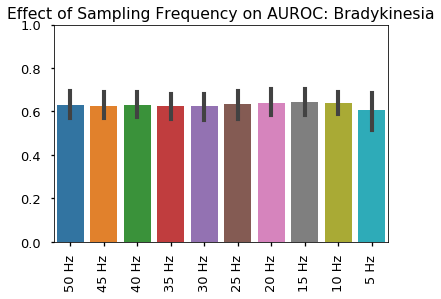

In [7]:
groups = watch_res_all['Sampling Rate'].values
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(watch_res_freq_all)):
    if len(watch_res_freq_all[i]['Random Forest']['auroc']) < 7:
        L = len(watch_res_freq_all[i]['Random Forest']['auroc'])
        watch_res_freq_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[groups[i]] = watch_res_freq_all[i]['Random Forest']['auroc']   
    tremor_auc = watch_res_freq_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(tremor_auc)) #mean across visits
    auc_std.append(np.nanstd(tremor_auc))

sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.ylim([0,1.0])
plt.title('Effect of Sampling Frequency on AUROC: Bradykinesia')
plt.savefig('Results/Downsample/BinaryWatchBrady.png',format='png',dpi=1000)

## Sensor

In [8]:
Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel Data ' + str(freq) + 'Hz.csv',index_col=0)
Dataorig = Dataorig.reset_index(drop=True)
Dataorig

,Subject,Visit,Task,Bradykinesia,Tremor,RMSX,RMSY,RMSZ,rangeX,rangeY,...,Sen_X,Sen_Y,Sen_Z,RMS_mag,range_mag,mean_mag,var_mag,skew_mag,kurt_mag,Sen_mag
0,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.002012,0.001189,0.001473,0.046771,0.025215,...,2.079442,inf,inf,0.002763,0.031997,0.012087,0.006685,1.586963,3.440930,inf
1,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.001571,0.000664,0.000943,0.032512,0.012982,...,inf,inf,inf,0.001948,0.018679,0.008961,0.003821,0.792111,1.120109,inf
2,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.001636,0.000806,0.000940,0.035697,0.015714,...,inf,inf,inf,0.002052,0.017325,0.009069,0.004803,0.570437,-0.514593,inf
3,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.001362,0.000748,0.000950,0.032013,0.017934,...,inf,inf,inf,0.001821,0.017633,0.008145,0.004068,0.863242,0.222150,1.203973
4,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000849,0.000401,0.000684,0.018876,0.009048,...,inf,1.504077,inf,0.001162,0.012149,0.004803,0.003268,0.912597,0.050846,inf
5,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000455,0.000119,0.000289,0.008606,0.002958,...,inf,inf,inf,0.000552,0.003819,0.002534,0.001091,0.118269,-0.916164,inf
6,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000580,0.000104,0.000317,0.011592,0.001816,...,inf,inf,inf,0.000669,0.006445,0.002997,0.001484,1.056521,1.123121,1.386294
7,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000843,0.000140,0.000347,0.023986,0.003394,...,2.079442,1.791760,inf,0.000922,0.012750,0.003482,0.003024,1.941377,3.376599,1.252763
8,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000827,0.000150,0.000386,0.019940,0.003089,...,inf,1.098612,inf,0.000925,0.012225,0.003887,0.002507,2.190950,5.800020,2.079442
9,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000336,0.000120,0.000309,0.007243,0.002032,...,1.098612,inf,inf,0.000472,0.004272,0.002106,0.001066,0.824796,0.298783,inf


In [9]:
symptom = 'Tremor'

sensor_res_all = pd.DataFrame()

t1=time.time()

sensor_res_freq_all = []

for freq in [62.5,60,55,50,45,40,35,30,25,20,15,10,5]:
    
    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)
    
    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res['auroc std'] = np.nanstd(res_group['Random Forest']['auroc'])
    res = res[['Sampling Rate','auroc','auroc std']]
    sensor_res_all = pd.concat((sensor_res_all,res))
    sensor_res_freq_all.append(res_group)

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

62.5
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.348+/-0.216, prec=0.487+/-0.300, rec=0.301+/-0.181, auprc=0.490+/-0.263, auroc=0.707+/-0.157
60
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.349+/-0.217, prec=0.489+/-0.304, rec=0.296+/-0.186, auprc=0.495+/-0.263, auroc=0.713+/-0.157
55
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.341+/-0.215, prec=0.480+/-0.297, rec=0.291+/-0.188, auprc=0.494+/-0.262, auroc=0.716+/-0.156
50
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.339+/-0.217, prec=0.485+/-0.305, rec=0.288+/-0.189, auprc=0.495+/-0.262, auroc=0.708+/-0.158
45
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.336+/-0.214, prec=0.480+/-0.301, rec=0.284+/-0.184, auprc=0.491+/-0.263, auroc=0.713+/-0.155
40
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.333+/-0.212, prec=0.483+/-0.304, rec=0.284+/-0.177, auprc=0.487+/-0.265, auroc=0.701+/-0.156
35
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.327+/-0.207, prec=0.470+/-0.305, rec=0.273+/-0.179, auprc=0.484+/-0.263, auroc=0.705+/-0.157
30
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.326+/-0.205, prec=0.474+/-0.307, rec=0.274+/-0.175, auprc=0.483+/-0.262, auroc=0.700+/-0.162
25
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.310+/-0.187, prec=0.462+/-0.305, rec=0.263+/-0.149, auprc=0.471+/-0.257, auroc=0.698+/-0.162
20
Rows w Tremor 4976/16653 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.317+/-0.184, prec=0.467+/-0.307, rec=0.267+/-0.150, auprc=0.471+/-0.252, auroc=0.690+/-0.163
15
Rows w Tremor 4846/16267 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.277+/-0.150, prec=0.448+/-0.303, rec=0.242+/-0.121, auprc=0.457+/-0.247, auroc=0.674+/-0.165
10
Rows w Tremor 3674/12005 = 0.31
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.216+/-0.117, prec=0.414+/-0.292, rec=0.192+/-0.116, auprc=0.423+/-0.246, auroc=0.634+/-0.143
5
Rows w Tremor 857/2629 = 0.33
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.194+/-0.106, prec=0.423+/-0.331, rec=0.160+/-0.108, auprc=0.463+/-0.245, auroc=0.606+/-0.151
Elapsed time = 9.981 min


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


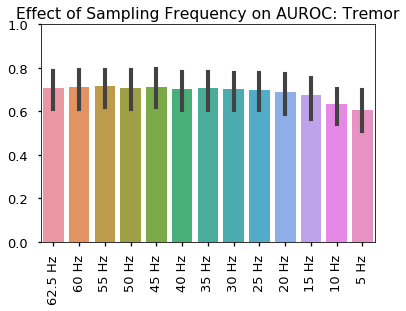

In [10]:
groups = sensor_res_all['Sampling Rate'].values
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(sensor_res_freq_all)):
    if len(sensor_res_freq_all[i]['Random Forest']['auroc']) < 7:
        L = len(sensor_res_freq_all[i]['Random Forest']['auroc'])
        sensor_res_freq_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[groups[i]] = sensor_res_freq_all[i]['Random Forest']['auroc']   
    tremor_auc = sensor_res_freq_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(tremor_auc)) #mean across visits
    auc_std.append(np.nanstd(tremor_auc))

sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.ylim([0,1.0])
plt.title('Effect of Sampling Frequency on AUROC: Tremor')
plt.savefig('Results/Downsample/BinarySensorTremor.png',format='png',dpi=1000)

In [11]:
symptom = 'Bradykinesia'

sensor_res_all = pd.DataFrame()

t1=time.time()

sensor_res_freq_all = []

for freq in [62.5,60,55,50,45,40,35,30,25,20,15,10,5]:
    
    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res['auroc std'] = np.nanstd(res_group['Random Forest']['auroc'])
    res = res[['Sampling Rate','auroc','auroc std']]
    sensor_res_all = pd.concat((sensor_res_all,res))
    sensor_res_freq_all.append(res_group)

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

62.5
Rows w Bradykinesia 7686/13739 = 0.56
Training Random Forest
f1_test=0.618+/-0.223, prec=0.622+/-0.282, rec=0.743+/-0.140, auprc=0.658+/-0.272, auroc=0.678+/-0.093
60
Rows w Bradykinesia 7686/13739 = 0.56
Training Random Forest
f1_test=0.620+/-0.225, prec=0.618+/-0.280, rec=0.745+/-0.126, auprc=0.648+/-0.275, auroc=0.668+/-0.100
55
Rows w Bradykinesia 7686/13739 = 0.56
Training Random Forest
f1_test=0.620+/-0.223, prec=0.620+/-0.280, rec=0.745+/-0.131, auprc=0.655+/-0.271, auroc=0.674+/-0.091
50
Rows w Bradykinesia 7686/13739 = 0.56
Training Random Forest
f1_test=0.620+/-0.227, prec=0.619+/-0.282, rec=0.745+/-0.127, auprc=0.654+/-0.275, auroc=0.668+/-0.094
45
Rows w Bradykinesia 7686/13739 = 0.56
Training Random Forest
f1_test=0.614+/-0.225, prec=0.619+/-0.283, rec=0.737+/-0.138, auprc=0.648+/-0.278, auroc=0.668+/-0.090
40
Rows w Bradykinesia 7686/13739 = 0.56
Training Random Forest
f1_test=0.618+/-0.226, prec=0.619+/-0.283, rec=0.744+/-0.133, auprc=0.653+/-0.268, auroc=0.671+/-0.

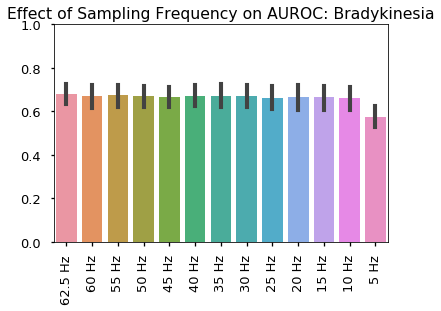

In [12]:
groups = sensor_res_all['Sampling Rate'].values
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(sensor_res_freq_all)):
    if len(sensor_res_freq_all[i]['Random Forest']['auroc']) < 7:
        L = len(sensor_res_freq_all[i]['Random Forest']['auroc'])
        sensor_res_freq_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[groups[i]] = sensor_res_freq_all[i]['Random Forest']['auroc']   
    tremor_auc = sensor_res_freq_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(tremor_auc)) #mean across visits
    auc_std.append(np.nanstd(tremor_auc))

sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.ylim([0,1.0])
plt.title('Effect of Sampling Frequency on AUROC: Bradykinesia')
plt.savefig('Results/Downsample/BinarySensorBrady.png',format='png',dpi=1000)

# Multiple Class Classifier

## Watch

In [13]:
symptom = 'Tremor'

watch_res_all = pd.DataFrame()

t1=time.time()

for freq in [50,45,40,35,30,25,20,15,10,5]:

    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOMultiClass(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res = res[['Sampling Rate','RMS']]
    watch_res_all = pd.concat((watch_res_all,res))

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

50
Training Random Forest
45
Training Random Forest
40
Training Random Forest
35
Training Random Forest
30
Training Random Forest
25
Training Random Forest
20
Training Random Forest
15
Training Random Forest
10
Training Random Forest
5
Training Random Forest
Elapsed time = 5.005 min


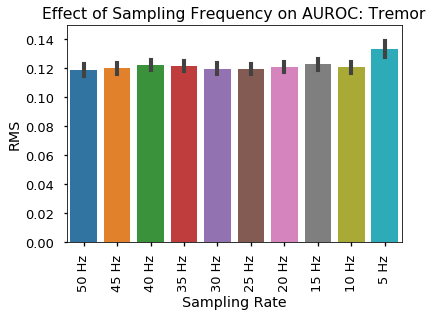

In [14]:
groups = watch_res_all['Sampling Rate']
RMS = watch_res_all['RMS']
sns.barplot(groups,RMS,ci='sd')
ax=plt.xticks(rotation=90)
plt.ylim([0,0.15])
plt.title('Effect of Sampling Frequency on AUROC: Tremor')
plt.savefig('Results/Downsample/MulticlassWatchTremor.png',format='png',dpi=1000)

In [15]:
symptom = 'Bradykinesia'

watch_res_all = pd.DataFrame()

t1=time.time()

for freq in [50,45,40,35,30,25,20,15,10,5]:

    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOMultiClass(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res = res[['Sampling Rate','RMS']]
    watch_res_all = pd.concat((watch_res_all,res))

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

50
Training Random Forest
45
Training Random Forest
40
Training Random Forest
35
Training Random Forest
30
Training Random Forest
25
Training Random Forest
20
Training Random Forest
15
Training Random Forest
10
Training Random Forest
5
Training Random Forest
Elapsed time = 4.062 min


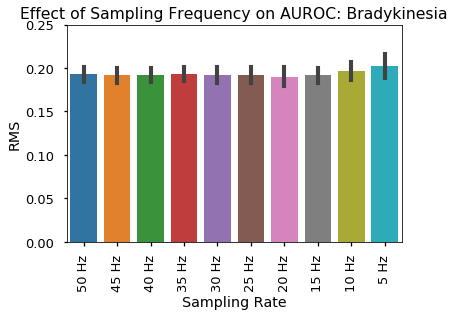

In [17]:
groups = watch_res_all['Sampling Rate']
RMS = watch_res_all['RMS']
sns.barplot(groups,RMS,ci='sd')
ax=plt.xticks(rotation=90)
plt.ylim([0,0.25])
plt.title('Effect of Sampling Frequency on AUROC: Bradykinesia')
plt.savefig('Results/Downsample/MulticlassWatchBrady.png',format='png',dpi=1000)

## Sensor

In [18]:
symptom = 'Tremor'

sensor_res_all = pd.DataFrame()

t1=time.time()

for freq in [62.5,60,55,50,45,40,35,30,25,20,15,10,5]:

    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOMultiClass(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res = res[['Sampling Rate','RMS']]
    sensor_res_all = pd.concat((watch_res_all,res))

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

62.5
Training Random Forest
60
Training Random Forest
55
Training Random Forest
50
Training Random Forest
45
Training Random Forest
40
Training Random Forest
35
Training Random Forest
30
Training Random Forest
25
Training Random Forest
20
Training Random Forest
15
Training Random Forest
10
Training Random Forest
5
Training Random Forest
Elapsed time = 8.612 min


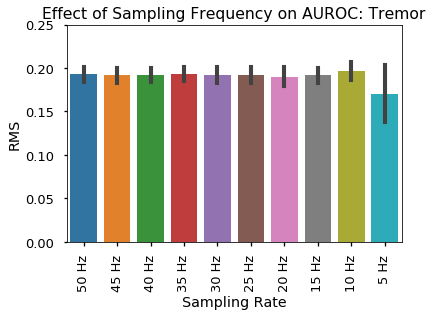

In [20]:
groups = sensor_res_all['Sampling Rate']
RMS = sensor_res_all['RMS']
sns.barplot(groups,RMS,ci='sd')
ax=plt.xticks(rotation=90)
plt.ylim([0,0.25])
plt.title('Effect of Sampling Frequency on AUROC: Tremor')
plt.savefig('Results/Downsample/MulticlassSensorTremor.png',format='png',dpi=1000)

In [21]:
symptom = 'Bradykinesia'

sensor_res_all = pd.DataFrame()

t1=time.time()

for freq in [62.5,60,55,50,45,40,35,30,25,20,15,10,5]:

    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOMultiClass(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res = res[['Sampling Rate','RMS']]
    sensor_res_all = pd.concat((watch_res_all,res))

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

62.5
Training Random Forest
60
Training Random Forest
55
Training Random Forest
50
Training Random Forest
45
Training Random Forest
40
Training Random Forest
35
Training Random Forest
30
Training Random Forest
25
Training Random Forest
20
Training Random Forest
15
Training Random Forest
10
Training Random Forest
5
Training Random Forest
Elapsed time = 10.948 min


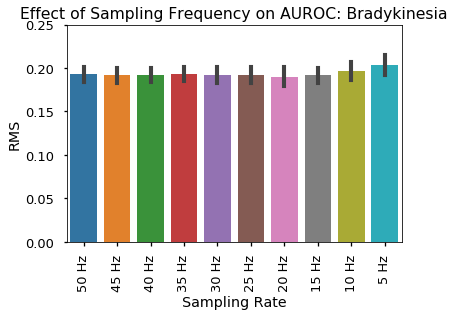

In [23]:
groups = sensor_res_all['Sampling Rate']
RMS = sensor_res_all['RMS']
sns.barplot(groups,RMS,ci='sd')
ax=plt.xticks(rotation=90)
plt.ylim([0,0.25])
plt.title('Effect of Sampling Frequency on AUROC: Bradykinesia')
plt.savefig('Results/Downsample/MulticlassSensorBrady.png',format='png',dpi=1000)

# Regressor

## Watch

In [24]:
symptom = 'Tremor'

watch_res_all = pd.DataFrame()

t1=time.time()

for freq in [50,45,40,35,30,25,20,15,10,5]:

    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestRegressor(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOMultiClass(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res = res[['Sampling Rate','RMS']]
    watch_res_all = pd.concat((watch_res_all,res))

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

50
Training Random Forest
45
Training Random Forest
40
Training Random Forest
35
Training Random Forest
30
Training Random Forest
25
Training Random Forest
20
Training Random Forest
15
Training Random Forest
10
Training Random Forest
5
Training Random Forest
Elapsed time = 30.286 min


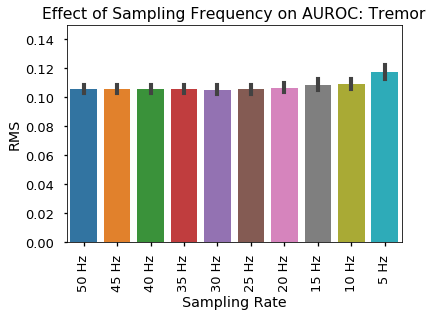

In [25]:
groups = watch_res_all['Sampling Rate']
RMS = watch_res_all['RMS']
sns.barplot(groups,RMS,ci='sd')
ax=plt.xticks(rotation=90)
plt.ylim([0,0.15])
plt.title('Effect of Sampling Frequency on AUROC: Tremor')
plt.savefig('Results/Downsample/RegressorWatchTremor.png',format='png',dpi=1000)

In [3]:
symptom = 'Bradykinesia'

watch_res_all = pd.DataFrame()

t1=time.time()

for freq in [50,45,40,35,30,25,20,15,10,5]:

    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestRegressor(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOMultiClass(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res = res[['Sampling Rate','RMS']]
    watch_res_all = pd.concat((watch_res_all,res))

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

50
Training Random Forest
45
Training Random Forest
40
Training Random Forest
35
Training Random Forest
30
Training Random Forest
25
Training Random Forest
20
Training Random Forest
15
Training Random Forest
10
Training Random Forest
5
Training Random Forest
Elapsed time = 22.774 min


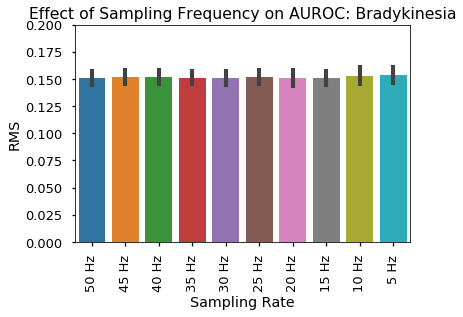

In [4]:
groups = watch_res_all['Sampling Rate']
RMS = watch_res_all['RMS']
sns.barplot(groups,RMS,ci='sd')
ax=plt.xticks(rotation=90)
plt.ylim([0,0.20])
plt.title('Effect of Sampling Frequency on AUROC: Bradykinesia')
plt.savefig('Results/Downsample/RegressorWatchBrady.png',format='png',dpi=1000)

## Sensor

In [5]:
symptom = 'Tremor'

sensor_res_all = pd.DataFrame()

t1=time.time()

for freq in [62.5,60,55,50,45,40,35,30,25,20,15,10,5]:

    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestRegressor(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOMultiClass(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res = res[['Sampling Rate','RMS']]
    sensor_res_all = pd.concat((watch_res_all,res))

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

62.5
Training Random Forest
60
Training Random Forest
55
Training Random Forest
50
Training Random Forest
45
Training Random Forest
40
Training Random Forest
35
Training Random Forest
30
Training Random Forest
25
Training Random Forest
20
Training Random Forest
15
Training Random Forest
10
Training Random Forest
5
Training Random Forest
Elapsed time = 49.102 min


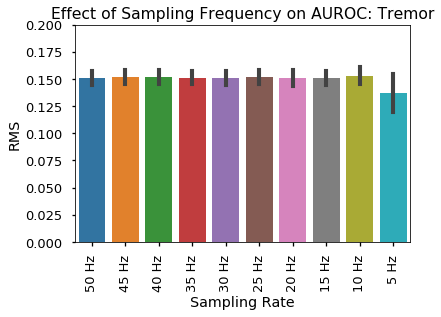

In [6]:
groups = sensor_res_all['Sampling Rate']
RMS = sensor_res_all['RMS']
sns.barplot(groups,RMS,ci='sd')
ax=plt.xticks(rotation=90)
plt.ylim([0,0.20])
plt.title('Effect of Sampling Frequency on AUROC: Tremor')
plt.savefig('Results/Downsample/RegressorSensorTremor.png',format='png',dpi=1000)

In [7]:
symptom = 'Bradykinesia'

sensor_res_all = pd.DataFrame()

t1=time.time()

for freq in [62.5,60,55,50,45,40,35,30,25,20,15,10,5]:

    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestRegressor(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOMultiClass(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res = res[['Sampling Rate','RMS']]
    sensor_res_all = pd.concat((watch_res_all,res))

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

62.5
Training Random Forest
60
Training Random Forest
55
Training Random Forest
50
Training Random Forest
45
Training Random Forest
40
Training Random Forest
35
Training Random Forest
30
Training Random Forest
25
Training Random Forest
20
Training Random Forest
15
Training Random Forest
10
Training Random Forest
5
Training Random Forest
Elapsed time = 85.106 min


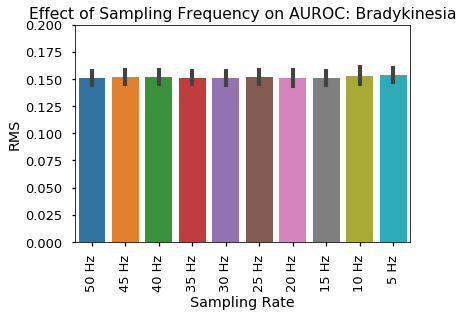

In [8]:
groups = sensor_res_all['Sampling Rate']
RMS = sensor_res_all['RMS']
sns.barplot(groups,RMS,ci='sd')
ax=plt.xticks(rotation=90)
plt.ylim([0,0.20])
plt.title('Effect of Sampling Frequency on AUROC: Bradykinesia')
plt.savefig('Results/Downsample/RegressorSensorBrady.png',format='png',dpi=1000)

In [13]:
sensor_res_all

,Sampling Rate,RMS
0,50 Hz,0.132951
0,50 Hz,0.150321
0,50 Hz,0.154305
0,50 Hz,0.156446
0,50 Hz,0.156905
0,50 Hz,0.159122
0,50 Hz,0.144993
0,50 Hz,0.149555
0,50 Hz,0.150646
0,50 Hz,0.151772


In [14]:
datadict = {'watch':{},'sensor':{}}
for freq in [50,45,40,35,30,25,20,15,10,5]:
    data = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data ' + str(freq) + 'Hz.csv',index_col=0)
    for s in data.columns.values[4:]:
        data = data[data[s]<np.finfo(np.float32).max]
    datadict['watch'][freq] = data[(data.Subject != 1020) & (data.Subject != 1030)].reset_index(drop=True)
for freq in [62.5,60,55,50,45,40,35,30,25,20,15,10,5]:
    data = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data ' + str(freq) + 'Hz.csv',index_col=0)
    for s in data.columns.values[4:]:
        data = data[data[s]<np.finfo(np.float32).max]
    datadict['sensor'][freq] = data[(data.Subject != 1020) & (data.Subject != 1030)].reset_index(drop=True)

In [27]:
t1=time.time()
results = {}

for mode in ['watch','sensor']:
    
    results[mode] = {}

    for symptom in ['Tremor','Bradykinesia']:
        
        results[mode][symptom] = {}
        
        results[mode][symptom]['Binary'] = {}
        binary_res_all = pd.DataFrame()
        binary_res_groups = []
        
        results[mode][symptom]['Multiclass'] = {}
        multi_res_all = pd.DataFrame()
        multi_res_groups = pd.DataFrame()
        
        results[mode][symptom]['Regressor'] = {}
        regress_res_all = pd.DataFrame()
        regress_res_groups = pd.DataFrame()

        for freq in datadict[mode].keys():

            data = datadict[mode][freq]
            Data = data.copy() #original unmodified dataframe
            Data=Data[~Data[symptom].isnull()]
            Data=Data.reset_index(drop=True) #reset index

            X = Data.iloc[:,5:].as_matrix()
            fnames = Data.iloc[:,5:].columns.values
            groups = Data.Subject.as_matrix()

            #Binary
            
            y = ((Data[symptom]>0)).values.astype(int)

            model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOCV(Data,X,y,groups,model)
            res['Sampling Rate'] = str(freq) + ' Hz'
            binary_res_all = pd.concat((binary_res_all,res))
            binary_res_groups.append(res_group)
            
            results[mode][symptom]['Binary']['res_all'] = binary_res_all.reset_index(drop=True)
            results[mode][symptom]['Binary']['res_groups'] = binary_res_groups

            #Multiple Classes

            y = Data[symptom].values.astype(int)

            model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOMultiClass(Data,X,y,groups,model)
            res['Sampling Rate'] = str(freq) + ' Hz'
            multi_res_groups = pd.concat((multi_res_groups,res))
            R = pd.DataFrame()
            R['RMS'] = [np.nanmean(multi_res_groups[multi_res_groups['Sampling Rate']==(str(freq) + ' Hz')]['RMS'])]
            R['Model'] = ['Random Forest']
            R['Sampling Rate'] = [str(freq) + ' Hz']
            multi_res_all = pd.concat([multi_res_all,R])

            results[mode][symptom]['Multiclass']['res_all'] = multi_res_all.reset_index(drop=True)
            results[mode][symptom]['Multiclass']['res_groups'] = multi_res_groups

            #Regressor

            y = Data[symptom].values.astype(int) #target 

            model = [RandomForestRegressor(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOMultiClass(Data,X,y,groups,model)
            res['Sampling Rate'] = str(freq) + ' Hz'
            regress_res_groups = pd.concat((regress_res_groups,res))
            R = pd.DataFrame()
            R['RMS'] = [np.nanmean(regress_res_groups[regress_res_groups['Sampling Rate']==(str(freq) + ' Hz')]['RMS'])]
            R['Model'] = ['Random Forest'] 
            R['Sampling Rate'] = [str(freq) + ' Hz']
            regress_res_all = pd.concat([regress_res_all,R])

            results[mode][symptom]['Regressor']['res_all'] = regress_res_all.reset_index(drop=True)
            results[mode][symptom]['Regressor']['res_groups'] = regress_res_groups
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\User

Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Elapsed time = 266.381 min


In [33]:
def barplotFeatures(results,mode,symptom,classifier):
    if 'RMS' in results[mode][symptom][classifier]['res_groups']:
        groups = results[mode][symptom][classifier]['res_groups']['Sampling Rate']
        RMS = results[mode][symptom][classifier]['res_groups']['RMS']
        sns.barplot(groups,RMS,ci='sd')
        plt.ylabel('RMS')
        m = results[mode][symptom][classifier]['res_all']['RMS'].max()
        m = math.ceil((m+.01)*20)/20
        plt.ylim([0,m])
    else:
        groups = results[mode][symptom][classifier]['res_all']['Sampling Rate'].values
        aucdf = pd.DataFrame()
        data = results[mode][symptom][classifier]['res_groups']
        for i in range(len(data)):
            aucdf[groups[i]] = data[i]['Random Forest']['auroc']
        sns.barplot(data=aucdf)
        plt.ylabel('AUROC')
        plt.ylim([0,1])
        
    ax = plt.xticks(rotation=90)
    plt.xlabel('Frequency')
    plt.title('Effect of Sampling Frequency on %s Model Performance: %s'%(classifier,symptom))

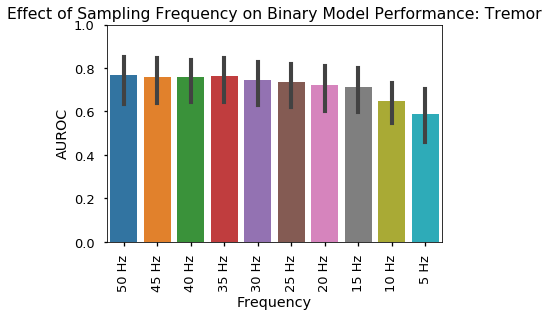

In [34]:
barplotFeatures(results,'watch','Tremor','Binary')

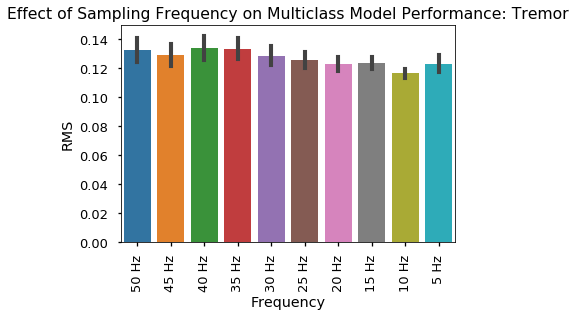

In [35]:
barplotFeatures(results,'watch','Tremor','Multiclass')

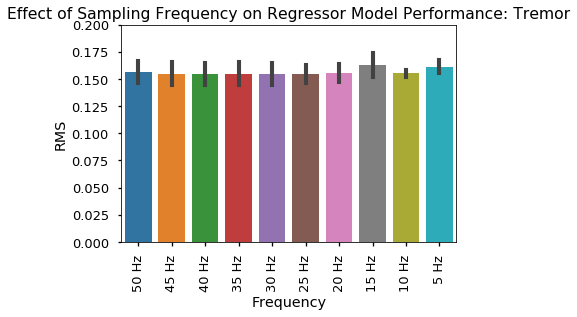

In [36]:
barplotFeatures(results,'watch','Tremor','Regressor')

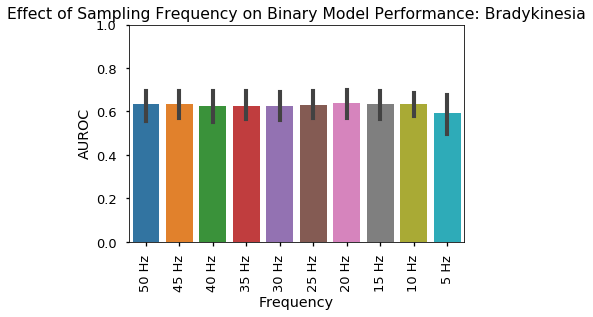

In [37]:
barplotFeatures(results,'watch','Bradykinesia','Binary')

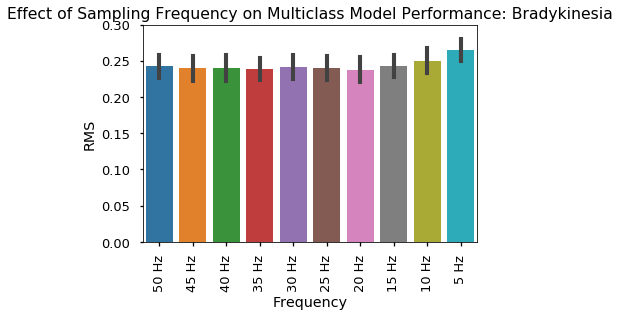

In [38]:
barplotFeatures(results,'watch','Bradykinesia','Multiclass')

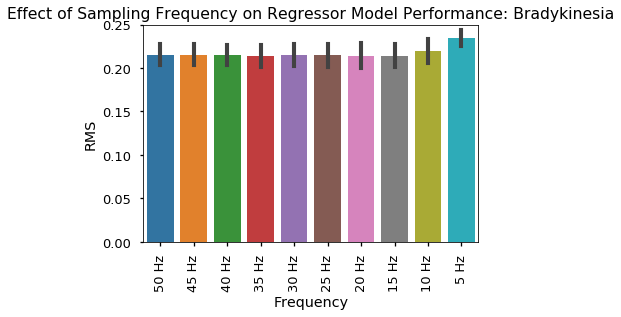

In [39]:
barplotFeatures(results,'watch','Bradykinesia','Regressor')

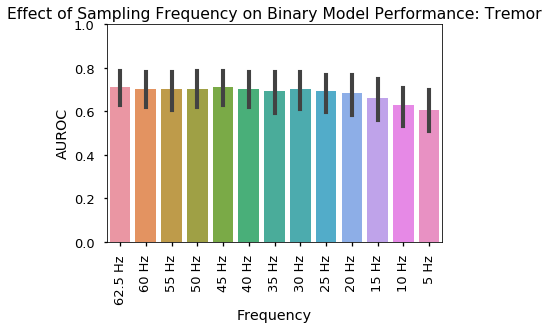

In [40]:
barplotFeatures(results,'sensor','Tremor','Binary')

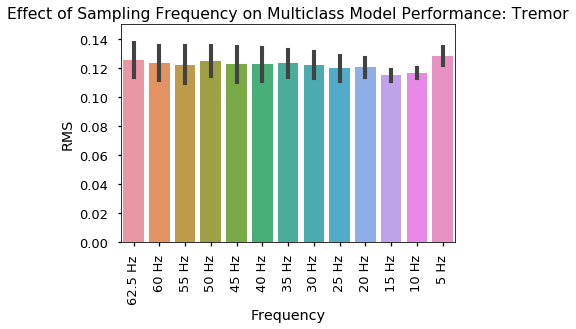

In [41]:
barplotFeatures(results,'sensor','Tremor','Multiclass')

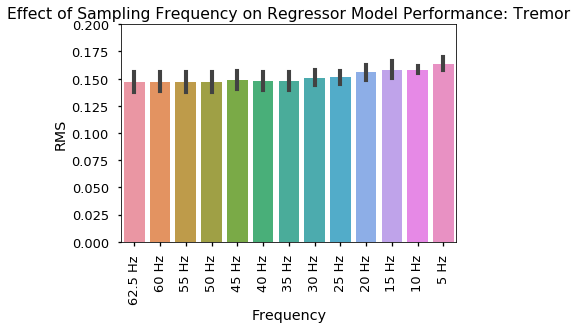

In [42]:
barplotFeatures(results,'sensor','Tremor','Regressor')

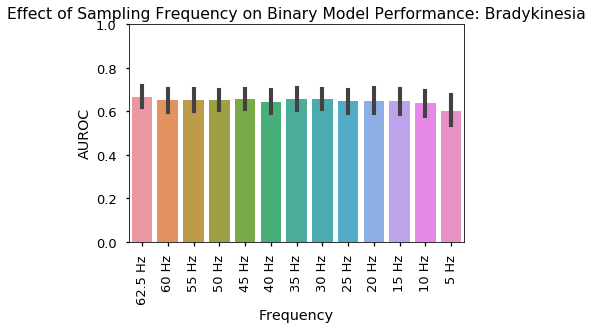

In [43]:
barplotFeatures(results,'sensor','Bradykinesia','Binary')

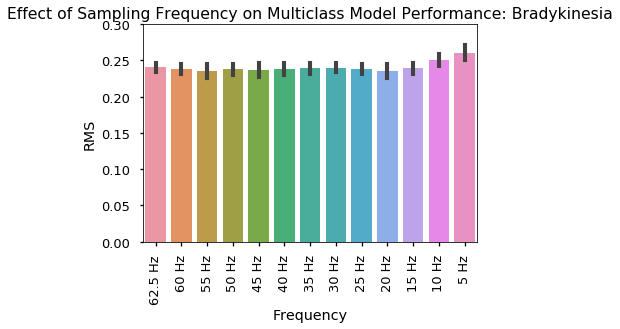

In [44]:
barplotFeatures(results,'sensor','Bradykinesia','Multiclass')

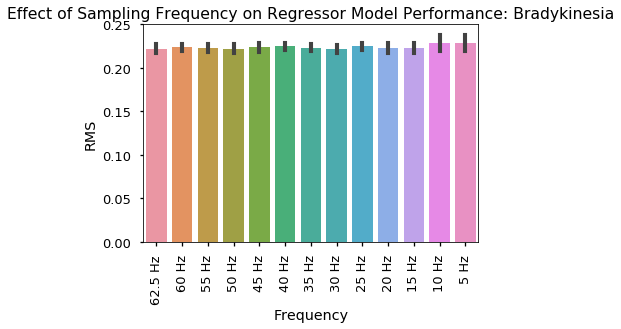

In [45]:
barplotFeatures(results,'sensor','Bradykinesia','Regressor')